In [1]:
!pip install yfinance numpy pandas scikit-learn tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.5/939.5 kB 16.8 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 4.8 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.7-cp310-cp310-linux_x86_64.whl size=300449 sha256=a2c8759347344621b6217dd66573bac2bf499c734924501d55578f3417ac8c05
  Stored in directory: /root/.cache/pip/wheels/8d/0e/f8/48eb93a200fca4c502d7590613616fa4d2c9533f7308f9e28a
Successfully built peewee


In [26]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Define the stock symbols (now 3 stocks)
stock_a = 'ADANIPORTS.NS'  # Coca-Cola
stock_b = 'ONGC.NS'  # PepsiCo
stock_c = 'BPCL.NS'  # Walmart (third stock)

# Download historical data for all three stocks
data_a = yf.download(stock_a, start='2004-01-01', end='2024-10-10')
data_b = yf.download(stock_b, start='2004-01-01', end='2024-10-10')
data_c = yf.download(stock_c, start='2004-01-01', end='2024-10-10')

# Preprocess the data (select relevant features and rename columns)
data_a = data_a[['Open', 'Close', 'Volume', 'Adj Close']].rename(columns={
    'Open': 'Open_A',
    'Close': 'Close_A',
    'Volume': 'Volume_A',
    'Adj Close': 'Adj_Close_A'
})

data_b = data_b[['Open', 'Close', 'Volume', 'Adj Close']].rename(columns={
    'Open': 'Open_B',
    'Close': 'Close_B',
    'Volume': 'Volume_B',
    'Adj Close': 'Adj_Close_B'
})

data_c = data_c[['Open', 'Close', 'Volume', 'Adj Close']].rename(columns={
    'Open': 'Open_C',
    'Close': 'Close_C',
    'Volume': 'Volume_C',
    'Adj Close': 'Adj_Close_C'
})

# Merge all three dataframes on the date index
data = pd.merge(data_a, data_b, left_index=True, right_index=True)
data = pd.merge(data, data_c, left_index=True, right_index=True)

# Drop any rows with NaN values (if any)
data.dropna(inplace=True)
data.head()
data.shape




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


(4156, 12)

In [27]:
# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create a DataFrame from the scaled data
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

print("Scaled data shape:", scaled_data.shape)

Scaled data shape: (4156, 12)


In [28]:
# Update the create_dataset function to include the third stock
def create_dataset(data, time_step):
    X, y_a, y_b, y_c = [], [], [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])  # Input for all features
        y_a.append(data[i + time_step - 1, 6])  # Close_A
        y_b.append(data[i + time_step - 1, 7])  # Close_B
        y_c.append(data[i + time_step - 1, 8])  # Close_C (for the third stock)
    return np.array(X), np.array(y_a), np.array(y_b), np.array(y_c)

# Set the time step (look-back period)
time_step = 60
X, y_a, y_b, y_c = create_dataset(scaled_data.values, time_step)

# Split data into training, validation, and testing sets
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_a_train, y_a_val, y_a_test = y_a[:train_size], y_a[train_size:train_size + val_size], y_a[train_size + val_size:]
y_b_train, y_b_val, y_b_test = y_b[:train_size], y_b[train_size:train_size + val_size], y_b[train_size + val_size:]
y_c_train, y_c_val, y_c_test = y_c[:train_size], y_c[train_size:train_size + val_size], y_c[train_size + val_size:]

# Print dataset shapes for verification
print("X_train shape:", X_train.shape)
print("y_a_train shape:", y_a_train.shape)
print("y_b_train shape:", y_b_train.shape)
print("y_c_train shape:", y_c_train.shape)

X_train shape: (2867, 60, 12)
y_a_train shape: (2867,)
y_b_train shape: (2867,)
y_c_train shape: (2867,)


In [29]:
import tensorflow as tf

def quantile_loss(q):
    def loss(y_true, y_pred):
        err = y_true - y_pred
        return tf.reduce_mean(tf.where(err >= 0, q * err, (q - 1) * err))
    return loss


In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Conv1D, MaxPooling1D,Bidirectional,TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

# Input layer
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x_encoded = TimeDistributed(Dense(8, activation='linear'))(input_layer)  # Further reduce to 8 dimensions
# x_encoded = TimeDistributed(Dense(4, activation='relu'))(x_encoded)
# Convolutional and LSTM layers
# x = TimeDistributed(Conv1D(filters=32, kernel_size=7, activation='relu'))(input_layer)
# x = MaxPooling1D(pool_size=2)(x)
x = Bidirectional(LSTM(64, return_sequences=False))(x_encoded)
x = Dropout(0.2)(x)
# x = LSTM(64, return_sequences=False)(x)
# x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)


# Separate dense output layers for each stock
output_stock_a = Dense(1, name='stock_a_output')(x)
output_stock_b = Dense(1, name='stock_b_output')(x)
output_stock_c = Dense(1, name='stock_c_output')(x)
# Define the model with two outputs
model = Model(inputs=input_layer, outputs=[output_stock_a, output_stock_b,output_stock_c])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss={'stock_a_output': quantile_loss(0.5), 'stock_b_output': quantile_loss(0.5), 'stock_c_output': quantile_loss(0.5)}, metrics=['mse', 'mse','mse'], loss_weights={'stock_a_output':0.5, 'stock_b_output': 0.5, 'stock_c_output': 0.5})  # Two 'mae' metrics for the two outputs

# Display the model summary
model.summary()



Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 60, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 60, 8)     │        104 │ input_layer_2[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 128)       │     37,376 │ time_distributed… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │      2,064 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stock_a_output      │ (None, 1)         │         17 │ dense_5[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stock_b_output      │ (None, 1)         │         17 │ dense_5[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stock_c_output      │ (None, 1)         │         17 │ dense_5[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 39,595 (154.67 KB)

 Trainable params: 39,595 (154.67 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model with a list of metrics for each output

# Fit the model
history = model.fit(
    X_train, 
    [y_a_train, y_b_train,y_c_train],  # Pass targets as a list of two arrays (multi-output)
    epochs=50, 
    batch_size=64, 
    validation_data=(X_val, [y_a_val, y_b_val,y_c_val]),  # Validation data for both stocks
    shuffle=True,  # For time series data, it's best to avoid shuffling
    callbacks=[early_stopping]  # Pass the EarlyStopping callback object here
)


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0869 - stock_a_output_mse: 0.0033 - stock_b_output_mse: 0.0270 - stock_c_output_mse: 0.0670 - val_loss: 0.0509 - val_stock_a_output_mse: 0.0175 - val_stock_b_output_mse: 0.0072 - val_stock_c_output_mse: 0.0034
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0208 - stock_a_output_mse: 0.0014 - stock_b_output_mse: 0.0018 - stock_c_output_mse: 0.0015 - val_loss: 0.0479 - val_stock_a_output_mse: 0.0178 - val_stock_b_output_mse: 0.0033 - val_stock_c_output_mse: 0.0063
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0165 - stock_a_output_mse: 0.0010 - stock_b_output_mse: 8.5664e-04 - stock_c_output_mse: 0.0011 - val_loss: 0.0454 - val_stock_a_output_mse: 0.0157 - val_stock_b_output_mse: 0.0030 - val_stock_c_output_mse: 0.0058
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0153 - stock_a_output_mse: 0.0014 - stock_b_output_mse: 6.9329e-04 - stock_c_output_mse: 8.9029e-04 - val_loss: 0.0410 - v

In [32]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Function to evaluate the metrics
def evaluate_metrics(y_test, y_pred, stock_name):
    print(f"Metrics for {stock_name}:")
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"R-squared: {r2}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}\n")

# Make predictions for the test set
y_pred_a, y_pred_b,y_pred_c = model.predict(X_test)  # Assuming the model returns two separate outputs

# Evaluate for Stock A
evaluate_metrics(y_a_test, y_pred_a, 'A')

# Evaluate for Stock B
evaluate_metrics(y_b_test, y_pred_b, 'B')
evaluate_metrics(y_c_test, y_pred_c, 'C')

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Metrics for A:
R-squared: 0.9646229454834736
Mean Squared Error (MSE): 0.00022583443095834354
Mean Absolute Error (MAE): 0.009730233597240573

Metrics for B:
R-squared: 0.9676156347211669
Mean Squared Error (MSE): 0.0016590548867853015
Mean Absolute Error (MAE): 0.03303209459173105

Metrics for C:
R-squared: 0.956184659185865
Mean Squared Error (MSE): 0.0015618774379542095
Mean Absolute Error (MAE): 0.028856909683580068



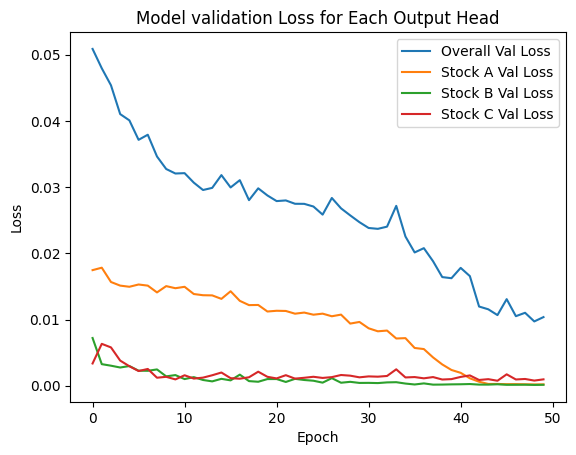

In [33]:
import matplotlib.pyplot as plt

# Overall Loss
# plt.plot(history.history['loss'], label='Overall Train Loss')
plt.plot(history.history['val_loss'], label='Overall Val Loss')

# Loss for Stock A
# plt.plot(history.history['stock_a_output_mse'], label='Stock A Train Loss')
plt.plot(history.history['val_stock_a_output_mse'], label='Stock A Val Loss')

# Loss for Stock B
# plt.plot(history.history['stock_b_output_mse'], label='Stock B Train Loss')
plt.plot(history.history['val_stock_b_output_mse'], label='Stock B Val Loss')

# Loss for Stock C
# plt.plot(history.history['stock_c_output_mse'], label='Stock C Train Loss')
plt.plot(history.history['val_stock_c_output_mse'], label='Stock C Val Loss')

# Customize the plot
plt.title('Model validation Loss for Each Output Head')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


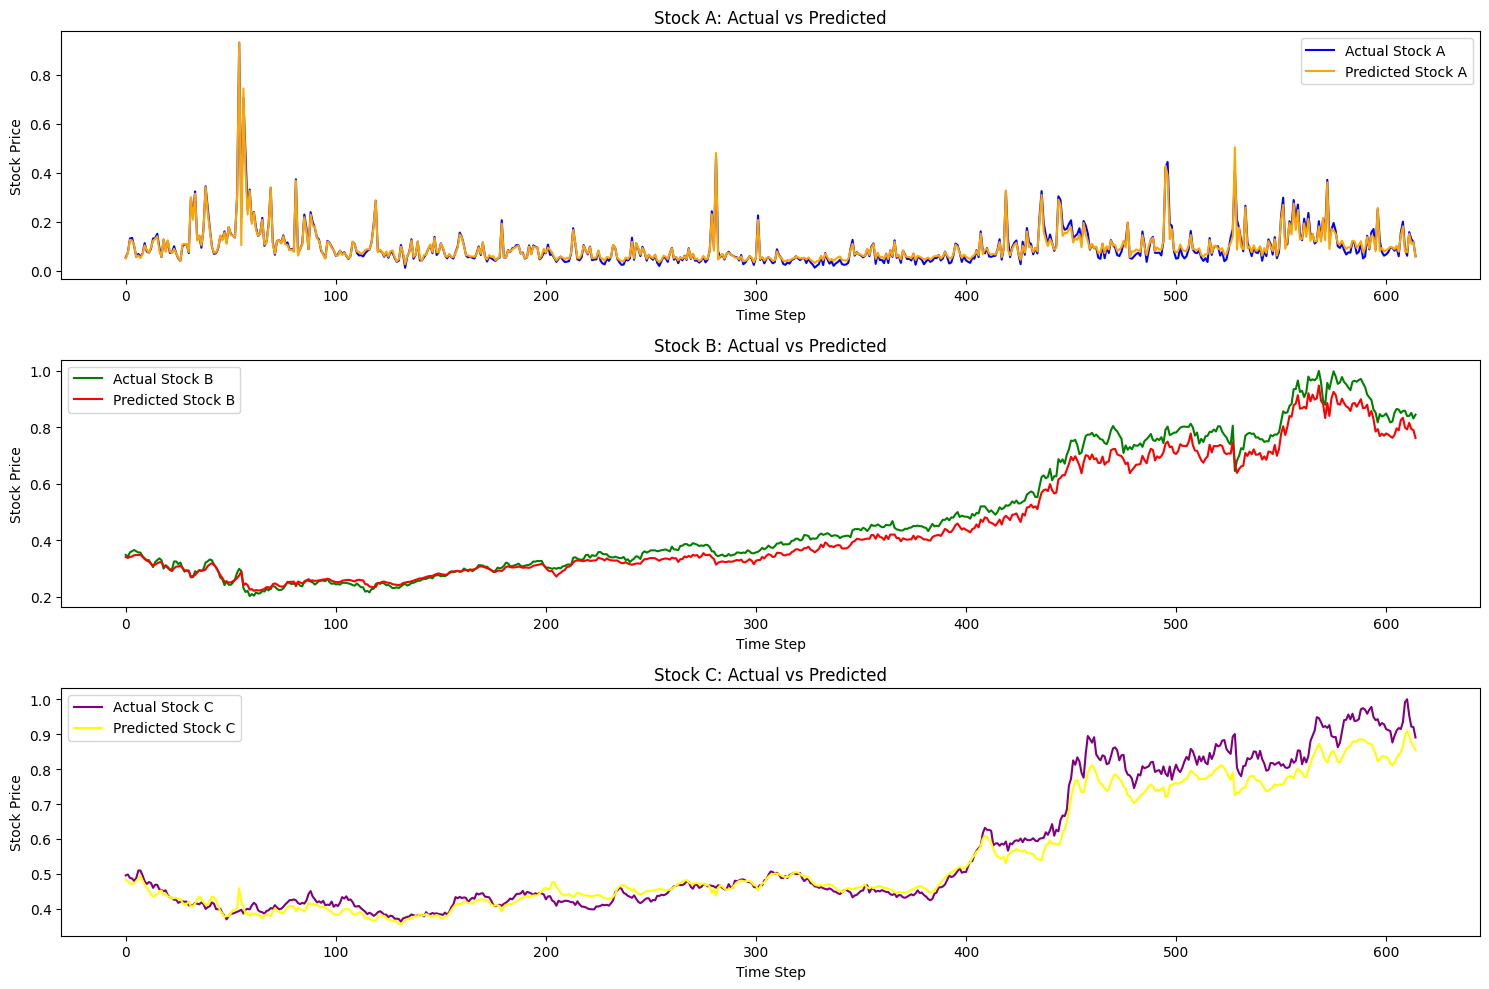

In [34]:
import numpy as np

# Make predictions
predictions = model.predict(X_test)

# Reshape predictions if necessary (to match the shape of y_test)
y_a_pred = predictions[0]
y_b_pred = predictions[1]
y_c_pred = predictions[2]

# Plotting actual vs. predicted values for each stock
plt.figure(figsize=(15, 10))

# Plot for Stock A
plt.subplot(3, 1, 1)  # 3 rows, 1 column, first subplot
plt.plot(y_a_test, label='Actual Stock A', color='blue')
plt.plot(y_a_pred, label='Predicted Stock A', color='orange')
plt.title('Stock A: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()

# Plot for Stock B
plt.subplot(3, 1, 2)  # 3 rows, 1 column, second subplot
plt.plot(y_b_test, label='Actual Stock B', color='green')
plt.plot(y_b_pred, label='Predicted Stock B', color='red')
plt.title('Stock B: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()

# Plot for Stock C
plt.subplot(3, 1, 3)  # 3 rows, 1 column, third subplot
plt.plot(y_c_test, label='Actual Stock C', color='purple')
plt.plot(y_c_pred, label='Predicted Stock C', color='yellow')
plt.title('Stock C: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()
